##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [60]:
#%pip install pandas 
#%pip install numpy
#%pip install pyarrow
#%pip install fastparquet
#%pip install matplotlib
#%pip install tqdm
#%pip install imblearn
#%pip install sklearn
#%pip install torch



# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [61]:
# Can have as many cells as you want for code

filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

<span style = "font-family: Vagabond; font-size: 50px; color:blue;">Imports</span>

In [62]:
import pandas as pd
import numpy as np
import pyarrow.parquet
import fastparquet
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

<span style = "font-family: Vagabond; font-size: 50px; color:blue;">Dataset Exploration</span>

In [63]:
df = pd.read_parquet(filepath)
display(df.head())

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_

##### Looking into object dtype we can see that columns with dtype string, datetime, floats and ints are casted as object

In [64]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',15)
df.select_dtypes("object").head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,hh_20,pop_20,hh_size_est,annual_income_est,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,n_months_last_bought_ltc,n_months_last_bought_507c37,n_months_last_bought_gi,n_months_last_bought_ltc_1280bf,n_months_last_bought_grp_6fc3e6,n_months_last_bought_grp_de05ae,n_months_last_bought_inv_dcd836,n_months_last_bought_grp_945b5a,n_months_last_bought_grp_6a5788,n_months_last_bought_ltc_43b9d5,n_months_last_bought_grp_9cdedf,n_months_last_bought_lh_d0adeb,n_months_last_bought_grp_1581d7,n_months_last_bought_grp_22decf,n_months_last_bought_lh_507c37,n_months_last_bought_lh_839f8a,n_months_last_bought_inv_e9f316,n_months_last_bought_grp_caa6ff,n_months_last_bought_grp_fd3bfb,n_months_last_bought_lh_e22a6a,n_months_last_bought_grp_70e1dd,n_months_la

In [65]:
display(pd.DataFrame(df.dtypes.value_counts(),columns = ["Counts"]))

,Counts
object,214
int64,46
float64,44


Looking at the "object" columns, we realised that it is a mix of variables - categorical, dates, numerical (both integers and floats). Hence, preprocessing would need to look at recasting of these object dtypes to their respective dtypes.

In [66]:
df[[col for col in df.columns if df[col].dtype == "object"]]

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,hh_20,pop_20,hh_size_est,annual_income_est,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,n_months_last_bought_ltc,n_months_last_bought_507c37,n_months_last_bought_gi,n_months_last_bought_ltc_1280bf,n_months_last_bought_grp_6fc3e6,n_months_last_bought_grp_de05ae,n_months_last_bought_inv_dcd836,n_months_last_bought_grp_945b5a,n_months_last_bought_grp_6a5788,n_months_last_bought_ltc_43b9d5,n_months_last_bought_grp_9cdedf,n_months_last_bought_lh_d0adeb,n_months_last_bought_grp_1581d7,n_months_last_bought_grp_22decf,n_months_last_bought_lh_507c37,n_months_last_bought_lh_839f8a,n_months_last_bought_inv_e9f316,n_months_last_bought_grp_caa6ff,n_months_last_bought_grp_fd3bfb,n_months_last_bought_lh_e22a6a,n_months_last_bought_grp_70e1dd,n_months_la

##### Additionally, we found that there are entries under column "n_months_last_bought_products" with negative months, which we were not able to interpret

In [67]:
df_n_mths = df.filter(regex = "n_months_last_bought_*")
df_n_mths[df_n_mths["n_months_last_bought_products"] < 0]

,n_months_last_bought_products,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,n_months_last_bought_ltc,n_months_last_bought_507c37,n_months_last_bought_gi,n_months_last_bought_ltc_1280bf,n_months_last_bought_grp_6fc3e6,n_months_last_bought_grp_de05ae,n_months_last_bought_inv_dcd836,n_months_last_bought_grp_945b5a,n_months_last_bought_grp_6a5788,n_months_last_bought_ltc_43b9d5,n_months_last_bought_grp_9cdedf,n_months_last_bought_lh_d0adeb,n_months_last_bought_grp_1581d7,n_months_last_bought_grp_22decf,n_months_last_bought_lh_507c37,n_months_last_bought_lh_839f8a,n_months_last_bought_inv_e9f316,n_months_last_bought_grp_caa6ff,n_months_last_bought_grp_fd3bfb,n_months_last_bought_lh_e22a6a,n_months_last_bought_grp_70e1dd,n_months_last_bought_grp_e04c3a,n_months_last_bought_grp_fe5fb8,n_months_last_bought_grp_94baec,n_months_last_bought_grp_e91421,n_months_last_bought_lh_f852af,n_months_last_bought_lh_947b15,n_months_last_bought_32c74c
18769,-4,73,73,9999,9999,73,73,8,9999,9999,9999,9999,73,73,9999,9999,9999,73,9999,9999,9999,9999,73,9999,9999,73,9999,9999,73,9999,9999,9999,9999
3260,-2,9999,9999,9999,9999,9999,9999,10,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
17875,-4,9999,121,9999,9999,9999,84,9999,9999,9999,9999,9999,9999,9999,9999,84,9999,9999,9999,9999,9999,9999,9999,9999,121,84,9999,9999,9999,9999,9999,9999,9999
4354,-1,9999,9999,9999,9999,9999,9999,9,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
10379,-3,381,9999,9999,9999,9999,381,2,9999,9999,9999,9999,381,9999,9999,9999,9999,381,9999,9999,9999,9999,9999,9999,9999,381,9999,9999,9999,9999,9999,9999,9999
2283,-1,45,9999,9999,9999,9999,45,2,9999,9999,9999,9999,45,9999,9999,9999,9999,45,9999,9999,9999,9999,45,9999,9999,45,9999,9999,9999,9999,9999,9999,9999
18333,-1,12,9999,9999,9999,33,12,9999,9999,9999,9999,9999,9999,9999,33,12,9999,12,9999,9999,9999,9999,9999,12,9999,12,9999,9999,9999,12,55,9999,9999
19933,-2,9999,9999,9999,9999,9999,35,10,9999,267,9999,9999,9999,9999,9999,267,9999,267,9999,9999,9999,9999,9999,9999,9999,267,9999,9999,9999,9999,9999,35,9999


Many NA values were also present, hence we may need do imputation

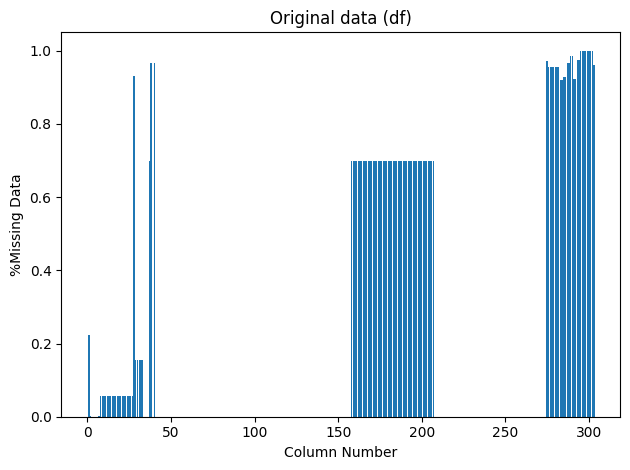

In [68]:
columnNames = df.columns
missingValueRatio_OG = [df[col].isna().sum()/ len(df[col]) for col in df.columns]

plt.bar(np.arange(len(columnNames)), missingValueRatio_OG)
plt.title("Original data (df)")
plt.ylabel("%Missing Data")
plt.xlabel("Column Number")

plt.tight_layout()
plt.show()

<span style = "font-family: Vagabond; font-size: 50px; color:blue;">Data Pre-processing</span>

In [69]:
df = pd.read_parquet(filepath)
df = df.set_index('clntnum')

df_n_mths = df.filter(regex = "n_months_last_bought_*")

#there were some negative values in the column which are invalid
df = df[df_n_mths["n_months_last_bought_products"] >= 0]

df.convert_dtypes(infer_objects = True)

df = df.dropna(axis = 1, how = "all") #drop columns that are alL NaN

In [70]:
#columns are categorised into date, numerical(numbers, last_bought, and float) and categorical
num_cols_manual = ['hh_20', 'pop_20', 'hlthclaim_amt', 'giclaim_amt']
last_bought_cols = df.filter(regex = ('n_months_since_lapse_*|n_months_last_bought_*')).columns
float_cols = df.filter(regex = ("ape_*|sumins_*|prempaid_*|lapse_ape_*")).columns
num_cols = list(num_cols_manual) + list(float_cols) + list(last_bought_cols)

cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in num_cols]
date_cols = ['min_occ_date', 'cltdob_fix']
cat_cols = [col for col in cat_cols if col not in date_cols]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], format = "%Y-%m-%d", errors = 'coerce')
    
#NaNs are filled and numerical columns are changed to type float
df[num_cols] = df[num_cols].fillna(value = np.nan)
df[num_cols]= df[num_cols].astype(float)

#get the remaining columns that did not fit into any of the categories and add to numerical columns
remaining_cols = df.columns.difference(num_cols + cat_cols + date_cols).tolist()
num_cols = num_cols + remaining_cols

#remove since this is the target variable
num_cols.remove('f_purchase_lh')

In [71]:
X = df.copy()
X = X.drop(['f_purchase_lh'], axis = 1)
y = df['f_purchase_lh']
y = y.fillna(0.0).astype("int64")

#Some values of the categorical columns are NoneType, change all these to NaN
X.replace({None: np.nan}, inplace = True)

#use number of days as features instead of datetime -> easier to handle numbers
X['days_since_last_purchase'] = (pd.to_datetime('now') - X['min_occ_date']).dt.days
X['age'] = (pd.to_datetime('now') - X['cltdob_fix']).dt.days

#date columns are filled using median
X[['days_since_last_purchase','age']] = X[['days_since_last_purchase','age']].fillna(X[['days_since_last_purchase','age']].median())

#scale the days since last purchased and age to be between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X[['days_since_last_purchase', 'age']])
X['days_since_last_purchase_scale'] = scaled_data[:,0]
X['age_scale'] = scaled_data[:,1]
   
#drop original date columns
X = X.drop(columns = date_cols, axis = 1)
X = X.drop(columns = X[['days_since_last_purchase', 'age']])

#NaNs in categorical columns are filled using the mode
cat_imputer = SimpleImputer(strategy = "most_frequent")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

#NaNs in numerical columns are filled using the median
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

#one-hot encoding for categorical columns 
X = pd.get_dummies(X, columns = cat_cols)

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X

C:\Users\Admin\AppData\Local\Temp\ipykernel_14192\2827747994.py:10: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  X['days_since_last_purchase'] = (pd.to_datetime('now') - X['min_occ_date']).dt.days
C:\Users\Admin\AppData\Local\Temp\ipykernel_14192\2827747994.py:11: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  X['age'] = (pd.to_datetime('now') - X['cltdob_fix']).dt.days


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_gi,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,

##### Checking for missing values in columns

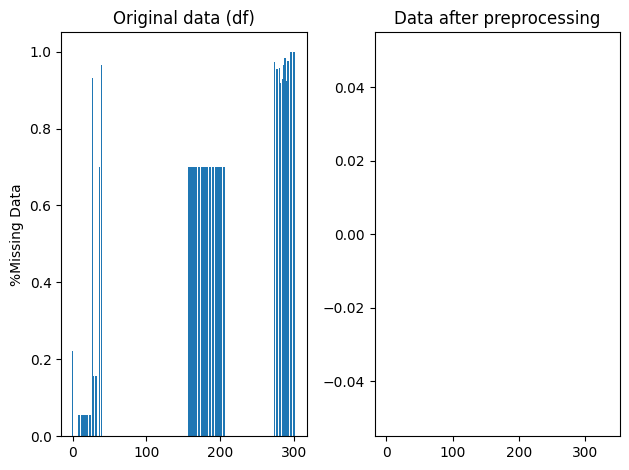

In [72]:
originalData = pd.read_parquet(filepath)
originalData = originalData.set_index("clntnum")

columnNames = originalData.columns
missingValueRatio_OG = [originalData[col].isna().sum()/ len(originalData[col]) for col in originalData.columns]

dataCleaned = X.copy()
columnNamesCleaned = dataCleaned.columns
missingValueRatio_2 = [dataCleaned[col].isna().sum()/ len(dataCleaned[col]) for col in dataCleaned.columns]
dataCleaned.columns = np.arange(len(dataCleaned.columns))


fig, (ax0,ax1) = plt.subplots(1,2)

ax0.bar(np.arange(len(columnNames)), missingValueRatio_OG)
ax0.set_title("Original data (df)")
ax0.set_ylabel("%Missing Data")

ax1.bar(np.arange(len(dataCleaned.columns)), missingValueRatio_2)
ax1.set_title("Data after preprocessing")
fig.tight_layout()
plt.show()

The final model we have decided to proceed with is the Neural Network, together with the SMOTE-ENN method for handling
the imbalanced dataset. SMOTE creates synthetic data around the minority class, while ENN filters out noisy and 
irrelavant samples from the dataset. Combining these two methods together will lead to an improved generalisation of the
model. 

The models we tested out were as follows: PCA followed by RandomForestClassifier, PCA followed by Logistic Regression, 
as well as two Neural Networks, one with weighted inputs, and the other using SMOTE-ENN. Other models such as Linear 
Regression and Gradient Boosting followed by Random Forest were also considered, but were not explored in-depth due to 
poor initial performance. We looked at two performance metrics to judge the effectiveness of our models: Accuracy Score 
and AUC-ROC Score. The results for our models are as follows:

1. PCA -> RandomForestClassifier: Accuracy = 0.9513, AUC-ROC Score = 0.6832
2. PCA -> Logistic Regression: Accuracy: 0.6850, AUC-ROC Score: 0.6505
3. Neural Network (Weighted): Accuracy: 0.8849, AUC-ROC Score: 0.6917
4. Neural Network (SMOTE-ENN): Accuracy: 0.9338, AUC-ROC Score: 0.7497

Given the scores we had above, we decided that across both metrics, the Neural Network using SMOTE-ENN performed the
best and would be the most effective model for this dataset.

<span style = "font-family: Vagabond; font-size: 50px; color: blue;">Neural Network with SMOTE-ENN

In [73]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [74]:
#SMOTE together with ENN is used to handle imbalanced datasets

smote_enn = SMOTEENN(random_state = 42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

100%|██████████| 57/57 [00:00<00:00, 1520.86it/s]

Test Accuracy: 93.38%
Test ROC AUC Score: 0.7345


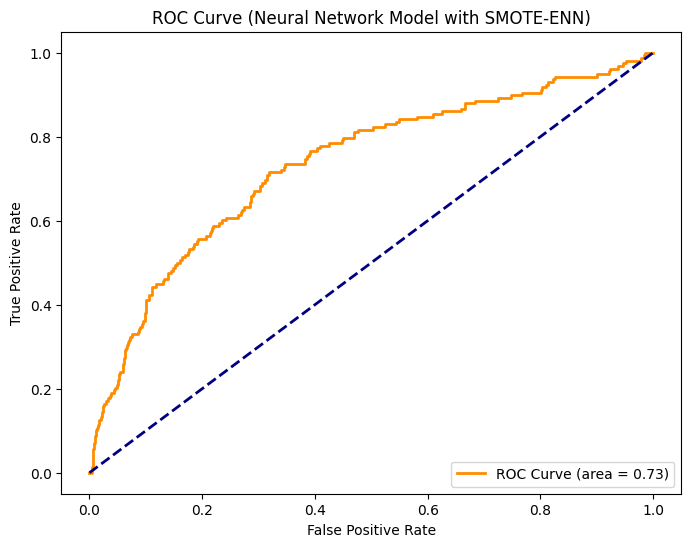

In [75]:
NNscaler_smote = StandardScaler()
X_train_smote = NNscaler_smote.fit_transform(X_resampled)
X_test_smote = NNscaler_smote.transform(X_test)

X_train_tensor_smote = torch.tensor(X_train_smote, dtype = torch.float32)
y_train_tensor_smote = torch.tensor(y_resampled, dtype = torch.float32)
X_test_tensor_smote = torch.tensor(X_test_smote, dtype = torch.float32)
y_test_tensor_smote = torch.tensor(y_test, dtype = torch.float32)

train_dataset_smote = TensorDataset(X_train_tensor_smote, y_train_tensor_smote)
test_dataset_smote = TensorDataset(X_test_tensor_smote, y_test_tensor_smote)
train_loader_smote = DataLoader(train_dataset_smote, batch_size = 64, shuffle = True)
test_loader_smote = DataLoader(test_dataset_smote, batch_size = 64, shuffle = False)

torch.manual_seed(42)

input_size_smote = X_train_smote.shape[1]
hidden_size_smote = 64
output_size_smote = 1
model_smote = NeuralNetwork(input_size_smote, hidden_size_smote, output_size_smote)

train_targets_smote = train_dataset_smote.tensors[1]
test_targets_smote = test_dataset_smote.tensors[1]
train_targets_smote = train_targets_smote.to(torch.int64)
test_targets_smote = test_targets_smote.to(torch.int64)

criterion_smote = nn.BCEWithLogitsLoss()
optimiser_smote = optim.Adam(model_smote.parameters(), lr = 0.001)

epochs = 10
for epoch in tqdm(range(epochs), desc = "Epochs"):
    model_smote.train()
    total_loss = 0.0
    for inputs, labels in train_loader_smote:
        optimiser_smote.zero_grad()
        outputs = model_smote(inputs)
        loss = criterion_smote(outputs.squeeze(), labels)
        loss.backward()
        optimiser_smote.step()
        
        total_loss += loss.item()
        
    average_loss = total_loss / len(train_loader_smote)

model_smote.eval()

with torch.no_grad():
    predictions_smote, all_labels_test_smote = [], []
    for inputs, labels in tqdm(test_loader_smote):
        outputs = model_smote(inputs)
        predictions_smote.extend(outputs.squeeze().cpu().numpy())
        all_labels_test_smote.extend(labels.cpu().numpy())
        
probabilities_smote = torch.sigmoid(torch.tensor(predictions_smote)).numpy()

#threshold of 0.5 is used to classify from probabilities
accuracy_smote = accuracy_score(all_labels_test_smote, (probabilities_smote > 0.5).astype(int))
roc_auc_test_smote = roc_auc_score(all_labels_test_smote, probabilities_smote)

print(f'Test Accuracy: {accuracy_smote * 100:.2f}%')
print(f'Test ROC AUC Score: {roc_auc_test_smote:.4f}')

#plotting of ROC Curve 
fpr_smote, tpr_smote, _smote = roc_curve(all_labels_test_smote, probabilities_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)
plt.figure(figsize = (8, 6))
plt.plot(fpr_smote, tpr_smote, color = 'darkorange', lw = 2, label = f'ROC Curve (area = {roc_auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Neural Network Model with SMOTE-ENN)')
plt.legend(loc = 'lower right')
plt.show()    

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [76]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    #PREPROCESSING
    hidden_data = hidden_data.set_index('clntnum')

    hidden_data_n_mths = hidden_data.filter(regex = "n_months_last_bought_*")
    hidden_data = hidden_data[hidden_data_n_mths["n_months_last_bought_products"] >= 0]
    hidden_data.convert_dtypes(infer_objects = True)
    hidden_data = hidden_data.dropna(axis = 1, how = "all")

    #columns are categorised into date, numerical(numbers, last_bought, and float) and categorical
    num_cols_manual = ['hh_20', 'pop_20', 'hlthclaim_amt', 'giclaim_amt']
    last_bought_cols = hidden_data.filter(regex = ('n_months_since_lapse_*|n_months_last_bought_*')).columns
    float_cols = hidden_data.filter(regex = ("ape_*|sumins_*|prempaid_*|lapse_ape_*")).columns
    num_cols = list(num_cols_manual) + list(float_cols) + list(last_bought_cols)

    cat_cols = [col for col in hidden_data.columns if hidden_data[col].dtype == 'object' and col not in num_cols]
    date_cols = ['min_occ_date', 'cltdob_fix']
    cat_cols = [col for col in cat_cols if col not in date_cols]

    for col in date_cols:
        hidden_data[col] = pd.to_datetime(hidden_data[col], format = "%Y-%m-%d", errors = 'coerce')
        
    #NaNs are filled and numerical columns are changed to type float
    hidden_data[num_cols] = hidden_data[num_cols].fillna(value = np.nan)
    hidden_data[num_cols]= hidden_data[num_cols].astype(float)

    #get the remaining columns that did not fit into any of the categories and add to numerical columns
    remaining_cols = hidden_data.columns.difference(num_cols + cat_cols + date_cols).tolist()
    num_cols = num_cols + remaining_cols

    #Some values of the categorical columns are NoneType, change all these to NaN
    hidden_data.replace({None: np.nan}, inplace = True)

    #use number of days as features instead of datetime -> easier to handle numbers
    hidden_data['days_since_last_purchase'] = (pd.to_datetime('now') - hidden_data['min_occ_date']).dt.days
    hidden_data['age'] = (pd.to_datetime('now') - hidden_data['cltdob_fix']).dt.days

    #date columns are filled using median
    hidden_data[['days_since_last_purchase','age']] = hidden_data[['days_since_last_purchase','age']].fillna(hidden_data[['days_since_last_purchase','age']].median())

    #scale the days since last purchased and age to be between 0 and 1
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(hidden_data[['days_since_last_purchase', 'age']])
    hidden_data['days_since_last_purchase_scale'] = scaled_data[:,0]
    hidden_data['age_scale'] = scaled_data[:,1]
    
    #drop original date columns
    hidden_data = hidden_data.drop(columns = date_cols, axis = 1)
    hidden_data = hidden_data.drop(columns = hidden_data[['days_since_last_purchase', 'age']])

    #NaNs in categorical columns are filled using the mode
    cat_imputer = SimpleImputer(strategy = "most_frequent")
    hidden_data[cat_cols] = cat_imputer.fit_transform(hidden_data[cat_cols])

    #NaNs in numerical columns are filled using the median
    hidden_data[num_cols] = hidden_data[num_cols].fillna(hidden_data[num_cols].median())

    #one-hot encoding for categorical columns 
    hidden_data = pd.get_dummies(hidden_data, columns = cat_cols)

    #Further preprocessing for NN
    hidden_data_scaled = NNscaler_smote.transform(hidden_data)

    ##LOADING MODEL
    with torch.no_grad():
        model_smote.eval()
        inputs = torch.tensor(hidden_data_scaled, dtype = torch.float32)
        predictions = model_smote(inputs)
        probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()
        result = [1 if i > 0.5 else 0 for i in probabilities]



    return result

##### Cell to check testing_hidden_data function

In [77]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

C:\Users\Admin\AppData\Local\Temp\ipykernel_14192\3935417484.py:45: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  hidden_data['days_since_last_purchase'] = (pd.to_datetime('now') - hidden_data['min_occ_date']).dt.days
C:\Users\Admin\AppData\Local\Temp\ipykernel_14192\3935417484.py:46: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  hidden_data['age'] = (pd.to_datetime('now') - hidden_data['cltdob_fix']).dt.days


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

C:\Users\Admin\AppData\Local\Temp\ipykernel_14192\3935417484.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!